*시작 전, 상단 메뉴 '파일' > '드라이브에 사본 저장' 을 선택하여 사본을 가지고, GPU 세션에 연결한 상태에서 작업을 진행해주시기 바랍니다.*  

# 문제


> **민지는 옷 쇼핑몰 사장입니다. 최근 쇼핑몰 이용 고객이 많아지면서 일손이 부족해지자, 민지는 AI를 활용하여 촬영한 옷 사진을 자동으로 맞는 카테고리에 업로드해주는 프로그램을 도입해보려고 합니다. 민지를 위해 옷 사진을 카테고리별로 분류해주는 분류(Classification) 알고리즘을 만들어주세요.**

# 데이터 설명
- https://drive.google.com/drive/folders/1FrmG41w2vqiz_S_-v_HakbM5Y1D129RF?usp=sharing 에 접속하여 '드라이브에 바로가기 추가' 를 하면 내 드라이브에 데이터를 업로드하지 않고도 데이터 로드가 가능합니다.
- 훈련 데이터(Train Data): 3191장의 옷 이미지와 각각의 label(카테고리)  
- 평가 데이터(Test Data):  798장의 옷 이미지  

- 각 이미지는 모두 (500, 500) 의 컬러(3 channels) 이미지입니다.
- 각 label은 모두 0 ~ 4 의 정수로, `0=tops`, `1=bottoms`, `2=outerwear`, `3=shoes`, `4=cap_and_hat` 을 의미합니다.  

# 목표
Train Data를 이용하여 Classification 모델을 만들고 학습시킨 후,  
학습이 완료된 모델을 가지고 Test Data의 이미지들을 각각 5가지 카테고리 (0, 1, 2, 3, 4) 중 하나로 분류하여  
예측값을 csv 파일로 Kaggle에 제출하시면 됩니다.

# 평가 지표
모델이 정확히 label을 예측한 비율인 **Accuracy**를 사용합니다.
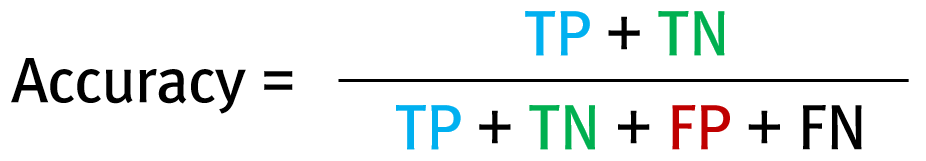

# 주의사항
- 팀별 submission 제출 가능 최대횟수는 **20번**입니다.
- 대회 종료 시각인 **PM 5:30** 까지만 제출이 가능합니다.
- submission 제출은 **각 팀별로 한 ID로만, Kaggle Team Name은 반드시 팀명으로 설정** 해주세요.

# 구글 드라이브 마운트

In [1]:
# Google drive mount 
# link 들어가셔서 코드를 받은 뒤 'Enter verification code'에 입력하시면 됩니다.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 폴더 이동
import os
ROOT = '/content/drive/MyDrive'  # 변경하지 마세요. 단, MyDrive가 오류난다면, My\ Drive로 적으세요.
DIR = 'Colab Notebooks/Dataset/data'  # 데이터와 ipynb파일이 있는 위치를 적으세요.

PATH = os.path.join(ROOT, DIR)
os.chdir(PATH)

# 패키지 임포트

In [3]:
import os
import glob
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataloader import Dataset
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torchvision import transforms, models
import torchvision.transforms as transforms

In [4]:
print(f"Python version: {sys.version.split(' ')[0]}")
print(f"Pytorch version: {torch.__version__}")

Python version: 3.7.12
Pytorch version: 1.9.0+cu111


# 데이터 로드 및 확인

In [5]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')

In [6]:
# numpy image shape: (batch size, height, width, channel)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(3191, 500, 500, 3)
(3191,)
(798, 500, 500, 3)


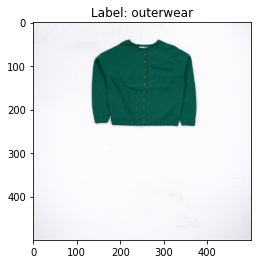

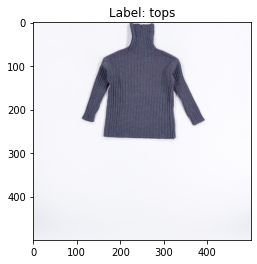

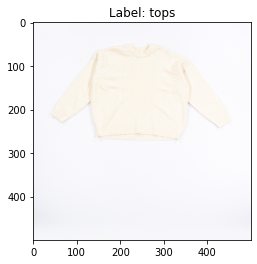

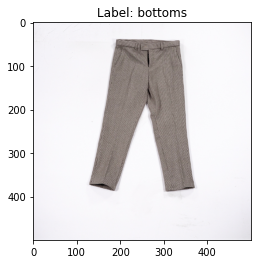

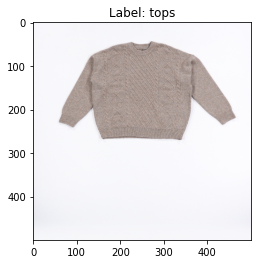

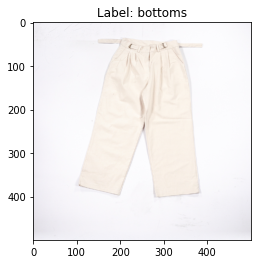

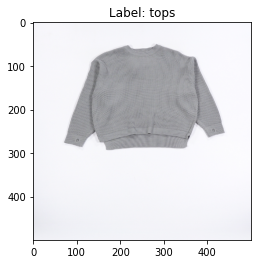

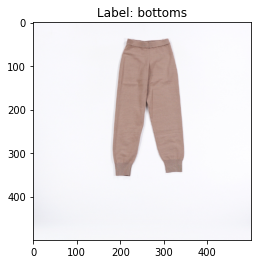

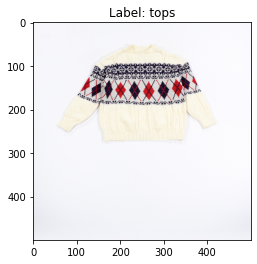

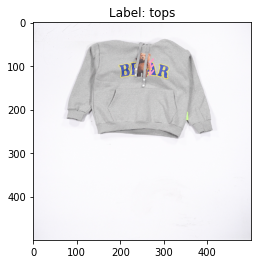

In [ ]:
# 이미지 데이터를 눈으로 확인해봅시다. 
classes = ['tops', 'bottoms', 'outerwear', 'shoes', 'cap_and_hat']  # 0=tops, 1=bottoms, 2=outerwear, 3=shoes, 4=cap_and_hat

def show_data(img, img_label):
    for i in np.random.randint(2800, 3000, 10):
        plt.imshow(img[i])
        plt.title(f"Label: {classes[img_label[i]]}")
        plt.show()
        
show_data(X_train, y_train)

In [7]:
# tensor image shape: (batch size, channel, height, width) 이므로 축을 변경해줍니다.
X_train = np.moveaxis(X_train, -1,1)
X_test = np.moveaxis(X_test, -1,1)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)

(3191, 3, 500, 500)
(3191,)
(798, 3, 500, 500)


# validation data 분할하기

In [68]:
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                  y_train,
                                                  test_size=0.2,  # train data : validation data = 8 : 2 가 되도록 분할합니다. 
                                                  stratify=y_train,
                                                  random_state=1120)

In [74]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)

(1428, 3, 500, 500)
(1428,)
(358, 3, 500, 500)
(358,)
(798, 3, 500, 500)


# Dataset, Dataloader 생성

In [10]:
X_train[0]

array([[[252, 252, 254, ..., 248, 249, 248],
        [253, 253, 253, ..., 249, 249, 248],
        [253, 253, 253, ..., 248, 248, 248],
        ...,
        [249, 249, 249, ..., 250, 250, 249],
        [249, 249, 249, ..., 250, 250, 249],
        [248, 249, 249, ..., 248, 249, 248]],

       [[252, 252, 254, ..., 249, 250, 249],
        [253, 253, 253, ..., 250, 249, 249],
        [253, 253, 253, ..., 249, 249, 249],
        ...,
        [248, 248, 248, ..., 249, 249, 248],
        [248, 248, 248, ..., 249, 249, 248],
        [247, 248, 249, ..., 247, 248, 247]],

       [[254, 255, 255, ..., 253, 254, 253],
        [255, 255, 255, ..., 254, 253, 253],
        [255, 255, 255, ..., 253, 253, 253],
        ...,
        [253, 253, 253, ..., 254, 254, 253],
        [253, 253, 253, ..., 254, 254, 253],
        [252, 253, 254, ..., 252, 253, 252]]], dtype=uint8)

기본적으로 image data는 pixel channel마다 0~255 integer로 구성되는데,  
신경망은 input이 0 ~ 1 범위일 때 가장 잘 동작하기 때문에 데이터를 255.0으로 나눕니다.  
이때 반드시 255가 아닌 255.0으로 나누어 0 ~ 1 사이의 float값을 가지도록 해야 합니다.  

In [11]:
# Dataset class 생성
class MyDataset(Dataset):
    def __init__(self, img, label=None, mode='train'):
        self.img = img
        self.mode = mode
        self.label = label

    def __len__(self):
        return len(self.img)

    def __getitem__(self, idx):
        if self.mode != 'test':
            return self.img[idx].astype('float32') / 255.0, self.label[idx]
        elif self.mode == 'test':
            return self.img[idx].astype('float32') / 255.0

In [12]:
train_dataset = MyDataset(img=X_train, label=y_train, mode='train')
val_dataset = MyDataset(img=X_val, label=y_val, mode='val')
test_dataset = MyDataset(img=X_test, label=None, mode='test')

In [62]:
# TODO: batch size를 자유롭게 변경해보세요!
BATCH_SIZE = 64

# 이 부분은 변경하지 마세요.
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [14]:
N_CLASSES = 5  # class가 0, 1, 2, 3, 4 이므로

# 모델링

In [93]:
# CNN Model
# TODO: 모델 구조를 자유롭게 변경해보세요!
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=11, stride=4),
            nn.Tanh()
        )
        
        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=32, kernel_size=5, stride=5, padding=2),
            nn.Tanh(),
        )
        
       
        
        self.flatten = nn.Flatten()
        
        self.linear_block1 = nn.Sequential(
            nn.Linear(20000, N_CLASSES),  # loss function으로 cross entropy를 사용하므로 마지막 layer에 activation function을 사용하지 않습니다.
        )
        
    def forward(self, x):
        out = self.conv_block1(x)
        out = self.conv_block2(out)
        out = self.flatten(out)
        out = self.linear_block1(out)
        
        return out

In [137]:
net = CNN()  # 모델을 선언합니다.
net.cuda()   # 모델을 GPU에 올려줍니다.

CNN(
  (conv_block1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(11, 11), stride=(4, 4))
    (1): Tanh()
  )
  (conv_block2): Sequential(
    (0): Conv2d(8, 32, kernel_size=(5, 5), stride=(5, 5), padding=(2, 2))
    (1): Tanh()
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_block1): Sequential(
    (0): Linear(in_features=20000, out_features=5, bias=True)
  )
)

torchsummary 패키지를 사용하면 pytorch 모델을 요약해서 볼 수 있습니다.  
설치가 되어있지 않은 분은 밑의 주석을 제거하고 실행하시면 됩니다.

In [ ]:
!pip install torchsummary  # torchsummary가 설치되어 있지 않으면 이 코드의 주석을 제거하고 실행하세요.

In [ ]:
from torchsummary import summary

summary(net, (3, 500, 500))

# 모델 컴파일

optimizer와 learning rate 등을 설정합니다. SGD를 사용해 보겠습니다.

In [138]:
# Optimizer 선언
# TODO: learning rate, weight decay, optimizer 종류 등을 자유롭게 변경해보세요!
lr = 1e-03
weight_decay = 1e-04
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=weight_decay)
#optimizer = optim.Adam(net.parameters(),lr=lr,weight_decay=weight_decay)

loss function으로는 cross entropy를 사용하겠습니다. 물론, 다른 함수를 사용하셔도 됩니다.

In [139]:
# Loss function 선언
criterion = nn.CrossEntropyLoss()

학습과정을 plot으로 보여주는 함수와 accuracy를 측정해주는 커스텀 함수입니다.

In [131]:
# 이 부분은 변경하지 마세요.
# loss plot, accuracy plot을 그려주는 함수
def plot(history, figsize=(15, 5)):
    fig, axes = plt.subplots(ncols=2, figsize=figsize)
    
    # Draw result plot
    for col, metric in enumerate(['loss', 'acc']):
        for phase in ['train', 'val']:
            axes[col].plot(history[f"{phase}_{metric}"], label=f"{phase}")
        axes[col].set_xlabel("epoch", fontsize=15)
        axes[col].set_ylabel(f"{metric}", fontsize=15)
        axes[col].legend()
    fig.suptitle("Loss & accuracy plot", fontsize=20)
    fig.show()

# 예측 결과를 가지고 accuracy를 계산해주는 함수 
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

# 모델 학습

In [146]:
# TODO: epoch 수를 자유롭게 변경해보세요!
epochs = 90

# 이 밑으로는 변경하지 않으셔도 됩니다.
history = {key: [] for key in ['train_loss', 'train_acc', 'val_loss', 'val_acc']}

# Train Model
for epoch in range(1, epochs + 1):
    net.train()  # 모델을 학습 모드로 변경 
    train_loss = 0
    train_acc = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.float().cuda(), labels.cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        train_acc += accuracy(outputs, labels)

    train_loss = train_loss / len(train_loader)
    train_acc = train_acc / len(train_loader)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)

    # Validation
    val_loss = 0
    val_acc = 0
    net.eval()  # 모델을 평가 모드로 변경
    
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.float().cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            val_acc += accuracy(outputs, labels)

    val_loss = val_loss / len(val_loader)
    val_acc = val_acc / len(val_loader)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    print(f"EPOCH [{epoch:02}/{epochs}] => TRAIN LOSS: {train_loss:0.4f} | TRAIN ACC: {train_acc:0.4f} | VAL LOSS: {val_loss:0.4f} | VAL ACC: {val_acc:0.4f}")

plot(history)

EPOCH [01/90] => TRAIN LOSS: 0.1923 | TRAIN ACC: 0.9447 | VAL LOSS: 0.5841 | VAL ACC: 0.7965
EPOCH [02/90] => TRAIN LOSS: 0.1885 | TRAIN ACC: 0.9438 | VAL LOSS: 0.5623 | VAL ACC: 0.8012
EPOCH [03/90] => TRAIN LOSS: 0.1852 | TRAIN ACC: 0.9464 | VAL LOSS: 0.5602 | VAL ACC: 0.7997
EPOCH [04/90] => TRAIN LOSS: 0.1809 | TRAIN ACC: 0.9492 | VAL LOSS: 0.5678 | VAL ACC: 0.8138
EPOCH [05/90] => TRAIN LOSS: 0.1795 | TRAIN ACC: 0.9493 | VAL LOSS: 0.5742 | VAL ACC: 0.8044
EPOCH [06/90] => TRAIN LOSS: 0.1767 | TRAIN ACC: 0.9503 | VAL LOSS: 0.5758 | VAL ACC: 0.8106
EPOCH [07/90] => TRAIN LOSS: 0.1784 | TRAIN ACC: 0.9441 | VAL LOSS: 0.5650 | VAL ACC: 0.8060
EPOCH [08/90] => TRAIN LOSS: 0.1737 | TRAIN ACC: 0.9487 | VAL LOSS: 0.5683 | VAL ACC: 0.8013
EPOCH [09/90] => TRAIN LOSS: 0.1717 | TRAIN ACC: 0.9484 | VAL LOSS: 0.5649 | VAL ACC: 0.8013
EPOCH [10/90] => TRAIN LOSS: 0.1663 | TRAIN ACC: 0.9533 | VAL LOSS: 0.5749 | VAL ACC: 0.8091
EPOCH [11/90] => TRAIN LOSS: 0.1661 | TRAIN ACC: 0.9530 | VAL LOSS: 0.

KeyboardInterrupt: ignored

생성된 loss plot과 accuracy plot을 가지고 모델을 평가하고, 개선 방향을 찾아보세요.

# validation 예측 결과 확인해 보기

모델 학습이 완료되었다면, 학습된 모델을 가지고 validation data를 얼마나 잘 예측했는지 눈으로 한 번 확인해 보겠습니다.

In [147]:
# 이 부분은 변경하지 마세요.
sample_images, sample_labels = next(iter(val_loader))

with torch.no_grad():  # 학습 단계가 아닌 검증 단계이므로 gradient가 흐르지 않게 설정
    net.eval()  # 모델을 평가 모드로 변경 
    
    sample_images = sample_images.float().cuda()
    outputs = net(sample_images)
    _, preds = torch.max(outputs, dim=1)

print(preds.shape)

torch.Size([64])


In [24]:
sample_images.shape

torch.Size([64, 3, 500, 500])

In [25]:
sample_images[0]

tensor([[[0.9725, 0.9686, 0.9686,  ..., 0.9765, 0.9765, 0.9765],
         [0.9686, 0.9725, 0.9725,  ..., 0.9765, 0.9765, 0.9725],
         [0.9686, 0.9725, 0.9725,  ..., 0.9725, 0.9725, 0.9765],
         ...,
         [0.9608, 0.9686, 0.9686,  ..., 0.9686, 0.9686, 0.9686],
         [0.9608, 0.9608, 0.9647,  ..., 0.9725, 0.9686, 0.9725],
         [0.9647, 0.9647, 0.9686,  ..., 0.9725, 0.9686, 0.9686]],

        [[0.9686, 0.9647, 0.9647,  ..., 0.9725, 0.9725, 0.9725],
         [0.9647, 0.9686, 0.9686,  ..., 0.9725, 0.9725, 0.9686],
         [0.9686, 0.9686, 0.9686,  ..., 0.9725, 0.9686, 0.9725],
         ...,
         [0.9647, 0.9686, 0.9647,  ..., 0.9647, 0.9647, 0.9647],
         [0.9647, 0.9608, 0.9608,  ..., 0.9686, 0.9647, 0.9686],
         [0.9608, 0.9608, 0.9647,  ..., 0.9686, 0.9647, 0.9647]],

        [[0.9882, 0.9843, 0.9843,  ..., 0.9922, 0.9922, 0.9922],
         [0.9843, 0.9882, 0.9882,  ..., 0.9922, 0.9922, 0.9882],
         [0.9882, 0.9882, 0.9882,  ..., 0.9922, 0.9882, 0.

validation data의 한 batch에 대한 정답과 우리 모델의 예측값을 확인해 볼 수 있습니다.

In [26]:
# 이 부분은 변경하지 마세요.
classes = ['tops', 'bottoms', 'outerwear', 'shoes', 'cap_and_hat']  # 0=tops, 1=bottoms, 2=outerwear, 3=shoes, 4=cap_and_hat

# sample image들에 대한 정답(label)과 모델의 예측값(pred)을 보여주는 함수 
def show_image(img, img_label, pred):
    for i in range(img.shape[0]):
        plt.imshow(img[i].permute(1, 2, 0))
        plt.title(f"Label: {classes[img_label[i]]}\n Pred: {classes[pred[i]]}")
        plt.show()
        
show_image(sample_images.cpu(), sample_labels.cpu(), preds.cpu())

Output hidden; open in https://colab.research.google.com to view.

# 예측결과 제출

모델이 잘 학습되었는지 확인까지 마쳤다면, 이제 test data에 대한 예측값을 생성하여 제출합니다.  

In [148]:
# 이 부분은 변경하지 마세요.
y_test_pred = []  # 예측 결과를 담을 list

net.eval()

with torch.no_grad():
    for inputs in test_loader:
        inputs = inputs.float().cuda()
        optimizer.zero_grad()
        outputs = net(inputs)
        _, preds = torch.max(outputs, dim=1)
        y_test_pred.append(preds)
        
y_test_pred = torch.cat(y_test_pred, dim=0)  # X_test에 대한 예측값 

In [142]:
y_test_pred.shape

torch.Size([798])

In [143]:
y_test_pred

tensor([1, 2, 0, 0, 1, 0, 1, 1, 2, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0,
        1, 0, 0, 2, 0, 1, 0, 2, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 2, 0,
        1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 1, 2, 1,
        1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1,
        2, 0, 1, 0, 0, 1, 1, 1, 1, 0, 2, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
        0, 0, 1, 1, 0, 0, 0, 0, 2, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 0, 2, 0, 1,
        1, 1, 2, 1, 0, 1, 0, 2, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 2, 0, 1, 1, 1,
        2, 0, 0, 2, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 2, 0,
        1, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 1, 1, 2, 0,
        1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 1, 0, 1, 2, 2, 0, 0, 0, 0,

이것이 우리 모델이 test data에 대해 예측한 값입니다.  

In [149]:
# submission 생성
id = pd.DataFrame(data=range(y_test_pred.shape[0]), columns=['id'])
submission = pd.DataFrame(data=y_test_pred.cpu(), columns=['y_test_pred'])
submission = pd.concat([id, submission], axis=1)
submission.shape

(798, 2)

제출 전, 생성된 submission이 총 (798행, 2열) 의 형태로 이루어져 있는지 꼭 확인하세요.  
개수가 맞지 않으면 채점이 되지 않습니다.

In [118]:
submission

,id,y_test_pred
0,0,1
1,1,0
2,2,0
3,3,0
4,4,1
...,...,...
793,793,1
794,794,1
795,795,1
796,796,4


In [105]:
# submission 파일을 저장할 폴더 만들기
ROOT = '/content/drive/MyDrive' 
DIR = 'Colab Notebooks/Dataset/'

SAVE_PATH = os.path.join(ROOT,DIR,'outpu')
if not os.path.exists(SAVE_PATH):
  os.mkdir(SAVE_PATH)
else:
  pass

아래 코드를 실행하면 해당 예측값이 'output' 폴더에 csv 파일로 저장되니, 다운받아서 Kaggle에 제출하시면 됩니다.  
고생하셨습니다. :)

In [150]:
team = "Happy_Creator"  # 반드시 팀명을 적어주세요.

# 이 밑은 수정하지 마세요.
from datetime import datetime, timedelta
kor_time = datetime.utcnow() + timedelta(hours=9)
timestamp = datetime.strftime(kor_time, "%H%M%S")
submission.to_csv(os.path.join(SAVE_PATH, f'./{team}_{timestamp}.csv'), index=False)
print(f"디렉토리 {SAVE_PATH}에 파일 '{team}_{timestamp}.csv' 저장 완료!")

디렉토리 /content/drive/MyDrive/Colab Notebooks/Dataset/outpu에 파일 'Happy_Creator_172805.csv' 저장 완료!
